In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, Subset
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from nilearn import plotting
import nilearn
from glob import glob
import audtorch
from audtorch.metrics.functional import pearsonr

from sklearn.metrics import roc_auc_score


/data_local/softwares/anaconda3/envs/PGT/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
/bin/sh: sox: command not found
SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


In [2]:
model_name = 'pred-default'
data = np.load('/data/agelgazzar/projects/state-spaces/outputs/{}.npz'.format(model_name))
labels = data['y']
outputs = data['output']
target = data['target']


In [33]:
mask_rois = np.array(np.load('/data/agelgazzar/projects/state-spaces/ho_networks.npy', allow_pickle=True).item()['Default'])


In [4]:
normal_args = np.where(labels==0)
anomaly_args = np.where(labels==1)
normal_outputs = outputs[normal_args].transpose(0,2,1)
normal_targets = target[normal_args].transpose(0,2,1)
anomaly_outputs = outputs[anomaly_args].transpose(0,2,1)
anomaly_targets = target[anomaly_args].transpose(0,2,1)


In [5]:
def calculate_score(data):
    
    X = data['output'].transpose(0,2,1)
    Y = data['target'].transpose(0,2,1)
    Z = data['y']

    
    mses = []
    corrs = []
    diff = []
    maes = [] 
    
    for (x,y) in zip(X, Y):
        
        x = torch.tensor(x)
        y = torch.tensor(y)
        corr = np.abs(pearsonr(x,y).numpy())#.mean()
        corr = corr.mean()
        mse = torch.mean(torch.square(torch.subtract(x,y)),axis=1).numpy().mean()
        mae = torch.mean(torch.abs(torch.subtract(x,y)),axis=1).numpy().mean()

        corrs.append(corr)
        mses.append(mse)
        maes.append(mae)
        diff.append(-corr)
    return mses, maes, corrs, diff,  Z


    
    
 
    

In [6]:
mses, maes, corrs, diff, labels = calculate_score(data)
auc = roc_auc_score(labels, diff)
auc

0.611625514403292

In [7]:
def calculate_score_roi(data,roi):
    
    X = data['output'].transpose(0,2,1)[:,roi,:]
    Y = data['target'].transpose(0,2,1)[:,roi,:]
    Z = data['y']

    
    mses = []
    corrs = []
    diff = []
    maes = [] 
    
    for (x,y) in zip(X, Y):
        
        x = torch.tensor(x)
        y = torch.tensor(y)
        corr = np.abs(pearsonr(x,y).numpy()).mean()
        mse = torch.mean(torch.square(torch.subtract(x,y))).numpy().mean()
        mae = torch.mean(torch.abs(torch.subtract(x,y))).numpy().mean()

        corrs.append(corr)
        mses.append(mse)
        maes.append(mae)
        diff.append(corr-mse)
    return mses, maes, corrs, diff,  Z


    
    
 
    

In [47]:
idx = 6



target_sample_a = anomaly_targets[idx]
output_sample_a = anomaly_outputs[idx]

target_sample_n = normal_targets[idx]
output_sample_n = normal_outputs[idx]


x_a = torch.tensor(output_sample_a)
y_a = torch.tensor(target_sample_a)

x_n = torch.tensor(output_sample_n)
y_n = torch.tensor(target_sample_n)


corrs_a = np.abs(pearsonr(x_a,y_a).numpy())
corrs_n = np.abs(pearsonr(x_n,y_n).numpy())

mse_a = torch.mean(torch.square(torch.subtract(x_a,y_a)),axis=1).numpy()
mse_n = torch.mean(torch.square(torch.subtract(x_n,y_n)),axis=1).numpy()

#print(corrs_a.mean(), corrs_n.mean())
print(mse_a.mean(), mse_n.mean())


#print(corrs_a.mean() - mse_a.mean() , corrs_n.mean() - mse_n.mean())

0.23750722 0.09686678


In [25]:
from nilearn import datasets

dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm', symmetric_split= True)
labels_cor = dataset.labels[1:]
dataset = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr25-2mm', symmetric_split= True)
ho_sub = dataset.maps
labels_sub = dataset.labels[1:]

regions = np.array(labels_cor+labels_sub)


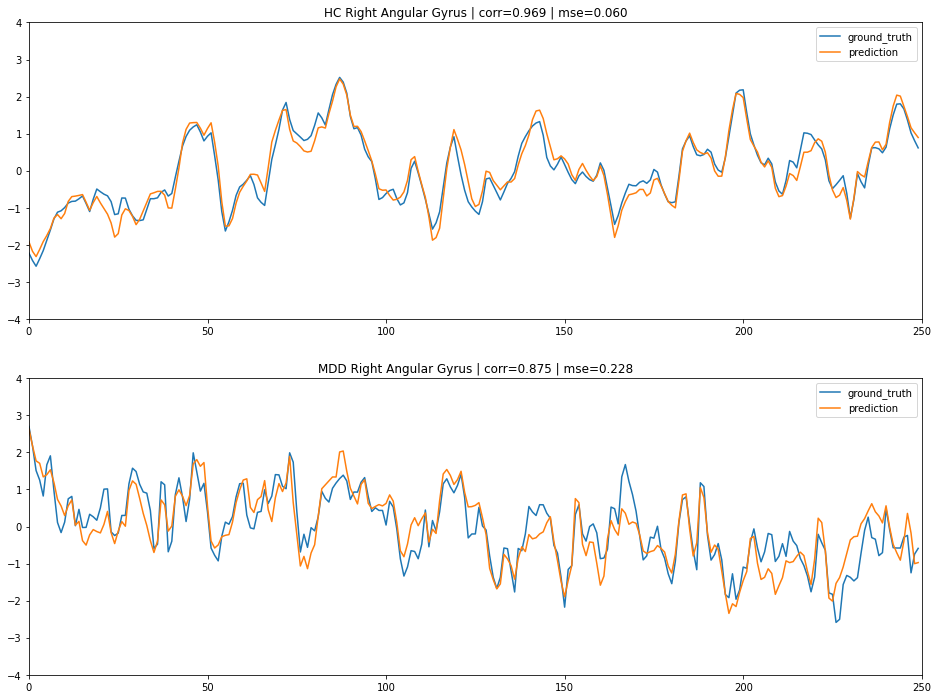

In [48]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,12))
ind = 8
roi = mask_rois[ind]
custom_xlim = (0, 250)
custom_ylim = (-4, 4)
plt.setp(ax[0], xlim=custom_xlim, ylim=custom_ylim)
plt.setp(ax[1], xlim=custom_xlim, ylim=custom_ylim)

#plot_subject(ax[0], input_sample, roi)
ax[0].set_title('HC '+ regions[roi] + ' | corr={:.3f} | mse={:.3f}'.format(corrs_n[ind][0],mse_n[ind]))
plot_subject(ax[0], target_sample_n, ind, name='ground_truth')
plot_subject(ax[0], output_sample_n, ind,  name='prediction')
ax[0].legend(loc='best')


ax[1].set_title('MDD '+regions[roi] + ' | corr={:.3f} | mse={:.3f}'.format(corrs_a[ind][0],mse_a[ind]))
plot_subject(ax[1], target_sample_a, ind, name='ground_truth')
plot_subject(ax[1], output_sample_a, ind, name='prediction')
ax[1].legend(loc='best')

#plt.savefig('/data/agelgazzar/projects/state-spaces/samples/mdd_default_{}_subj2.png'.format(roi))


In [21]:
def plot_subject(ax, subject, roi=-1, name='ground_truth'):
    if roi == -1:
        for region in subject:
            ax.plot(region)
    else:
        for region in subject[roi:roi+1]:
            ax.plot(region, label=name)

In [ ]:
np.arange(0,116,2)

In [656]:
batches = glob('./outputs/*')

for batch in batches:
    batch = np.load(batch)
    target = np.transpose(batch['target'],(0,2,1))
    output = np.transpose(batch['output'],(0, 2,1))
    for y_, y in (zip(output,target)):
        
    

IndentationError: expected an indented block (663379222.py, line 9)

In [146]:
batches = glob('./outputs/*')

preds = []
targets = []


for batch in batches:
    batch = np.load(batch)
    targets.append(np.transpose(batch['target'],(0,2,1)))
    preds.append(np.transpose(batch['output'],(0, 2,1)))

preds = np.concatenate(preds,axis=0)
targets = np.concatenate(targets,axis=0)


In [268]:
preds = np.transpose(ouptut['output'],(0,2,1))
targets = np.transpose(ouptut['target'], (0,2,1))

In [269]:
targets.shape

(500, 116, 50)

In [277]:
rois_mse = np.mean(np.square(np.subtract(targets,preds)),axis=0)
rois_mse_mean = np.mean(rois_mse,axis=1)
rois_mse_sd = np.std(rois_mse,axis=1)

In [278]:
sort_inds = np.argsort(rois_mse_mean)
rois_mse_sorted_m = rois_mse_mean[sort_inds]
rois_mse_sorted_sd = rois_mse_sd[sort_inds]

regions = np.array(regions)
rois_sorted = regions[sort_inds]

In [332]:
sort_inds

array([ 83,  11,  60,  31,  88,  59,  25,  54,  19,  23,  18,  90,  69,
        65,  49,  67,  96,  93,  63,  87,  47, 103,  62,   2,  14,  29,
         6,  45,  79,  46,  58,  55, 110,  81,  66,  33,  39, 100, 107,
       114,  99,  98,   7,   4,  22, 102,   9,  17,   5,  80,  71,  48,
        42,  53,  28,  13, 104, 105,  68,  26,  77,  76,  52,  24,  10,
        78,  64, 106,  16,   1,  86,  73,  38,  95, 101,  72, 112,  85,
        36,  41,  15,  37, 111,  50,   3,  44,  43,  82,  84,  91,  74,
        32,   0,  30,  57,  75,  27, 109,  56, 113,   8, 108,  97,  92,
        35,  12,  94,  21,  61,  40,  20,  89,  51,  70,  34, 115])

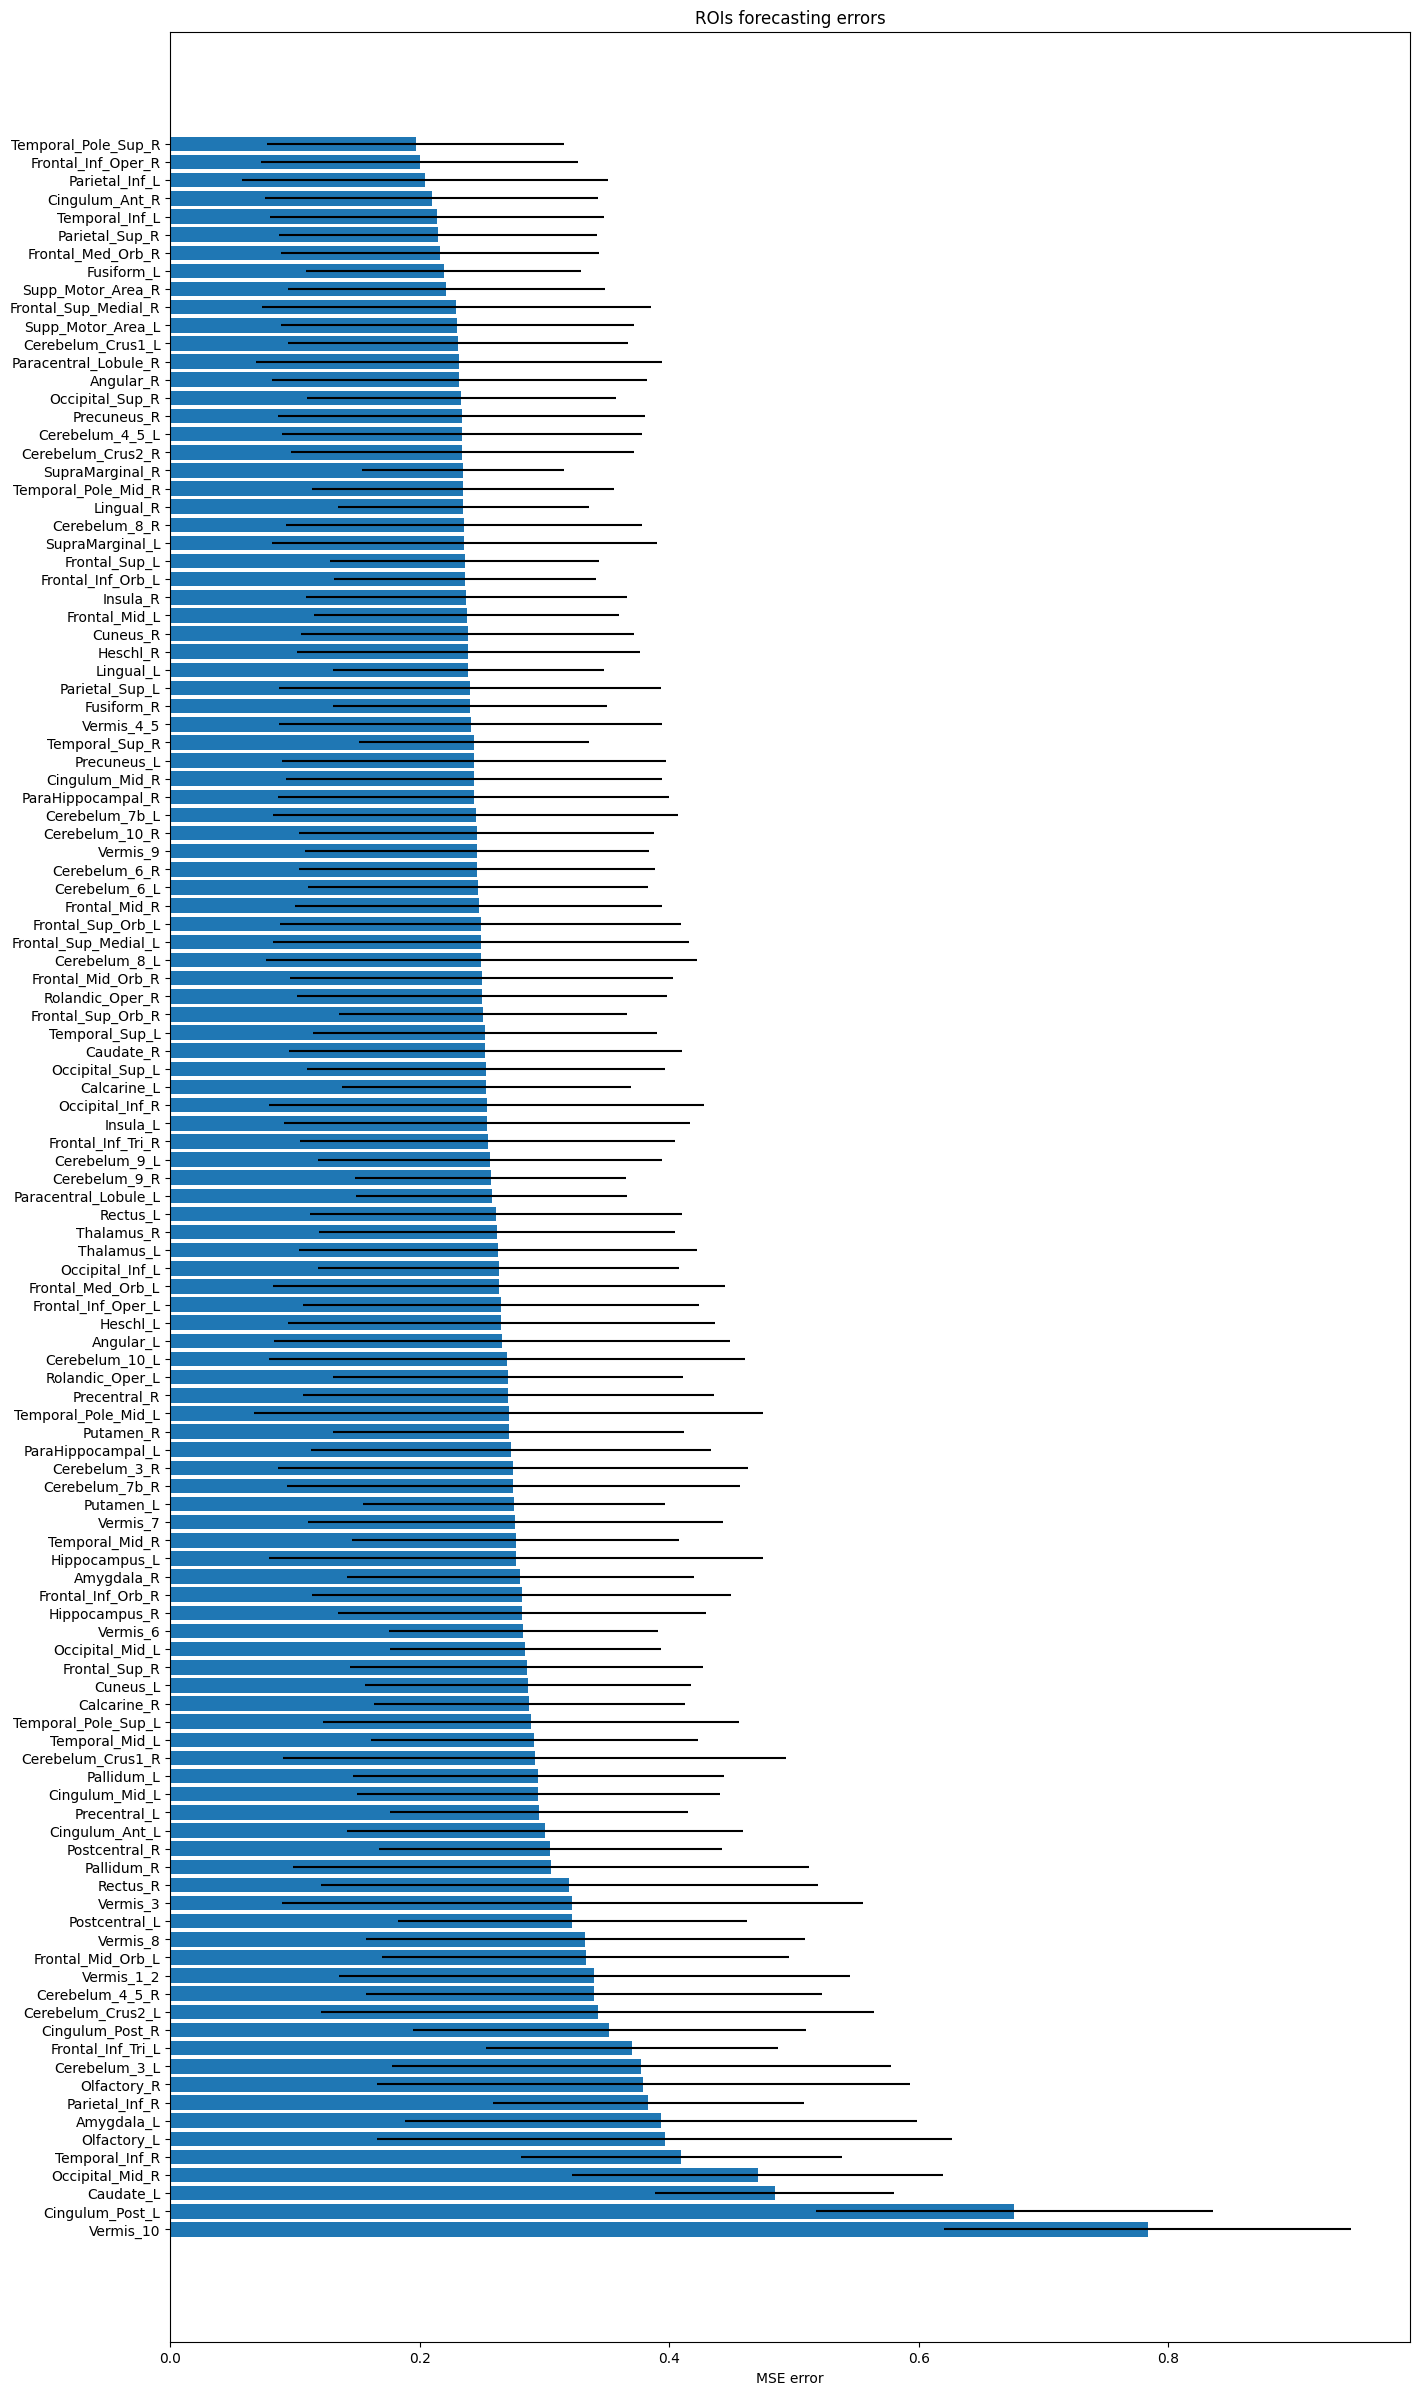

In [280]:
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(16,30))

# Example data
y_pos = np.arange(len(rois_sorted))
#plt.rcParams.update({'font.size': 22})
ax.barh(rois_sorted, rois_mse_sorted_m, xerr=rois_mse_sorted_sd)
ax.set_yticks(y_pos, labels=rois_sorted)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('MSE error')
ax.set_title('ROIs forecasting errors')

plt.savefig('rois_errors_t=50.pdf', dpi=1000)

In [1423]:
#df_h = pd.read_csv('csvfiles/ukbb_MDD_train.csv')

c = 0
for i in range(len(df_h)):
    tc = df_h['tc_file'].iloc[i].replace('ATLAS','HO')
    if not os.path.isfile(tc):
        print(tc)


In [1422]:
df_h = df_h[df_h.ID != 1641691]

In [1771]:
a = np.load("outputs/abide_linear.npy")
a.shape

(118, 118)

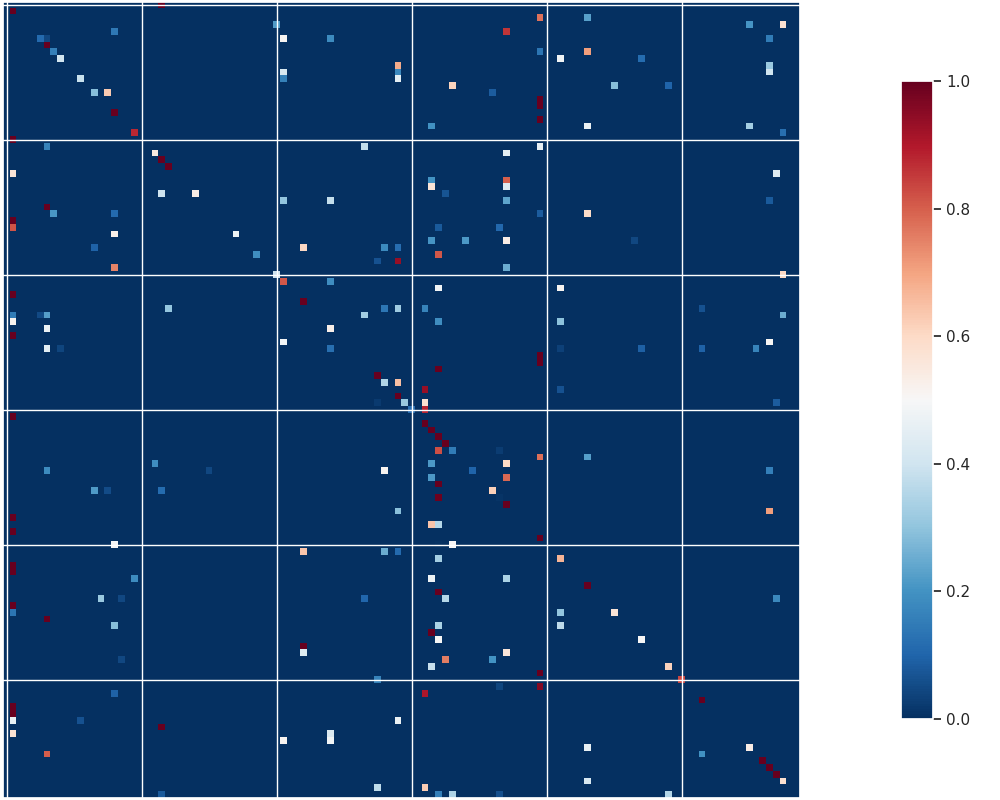

In [1772]:
import numpy as np
from nilearn import plotting

plotting.plot_matrix(a, figure=(10, 8))

In [1755]:
hc_nodes = np.argsort(a.sum(axis=0))

In [1683]:
np.diagonal(a)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.2655511 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.9968443 , 0.26777732, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.2824874 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [1684]:
np.sum(a,axis=1)

array([1.        , 1.        , 0.9999998 , 1.        , 1.        ,
       1.0000001 , 0.99999994, 0.99999994, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.0000001 , 1.        ,
       1.        , 1.        , 0.9999999 , 1.0000001 , 0.9999999 ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.99999994, 1.        ,
       1.        , 1.0000001 , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.99999994, 1.        , 1.        , 1.        , 1.        ,
       0.99999994, 1.0000001 , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.0000001 , 1.        , 1.        , 1.        ,
       0.99999994, 1.        , 1.        , 1.        , 0.99999

In [1685]:
mask_rois

array([ 9, 16, 17, 20, 21, 22, 23, 40, 41, 55, 59, 69])

In [1686]:
a[69].argmax()

108

In [1758]:
regions[hc_nodes]

array(['Left Frontal Pole', 'Right Temporal Occipital Fusiform Cortex',
       'Left Temporal Occipital Fusiform Cortex',
       'Right Temporal Fusiform Cortex, posterior division',
       'Left Temporal Fusiform Cortex, posterior division',
       'Right Lingual Gyrus',
       'Right Parahippocampal Gyrus, posterior division',
       'Left Parahippocampal Gyrus, posterior division',
       'Left Parahippocampal Gyrus, anterior division',
       'Right Frontal Orbital Cortex', 'Right Cuneal Cortex',
       'Left Cuneal Cortex', 'Left Precuneous Cortex',
       'Right Cingulate Gyrus, posterior division', 'Right Amygdala',
       'Left Cingulate Gyrus, anterior division',
       'Right Paracingulate Gyrus', 'Left Paracingulate Gyrus',
       'Right Subcallosal Cortex',
       'Left Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)',
       'Left Occipital Fusiform Gyrus', 'Right Occipital Fusiform Gyrus',
       'Left Frontal Operculum Cortex', 'Right Frontal Operculu